In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


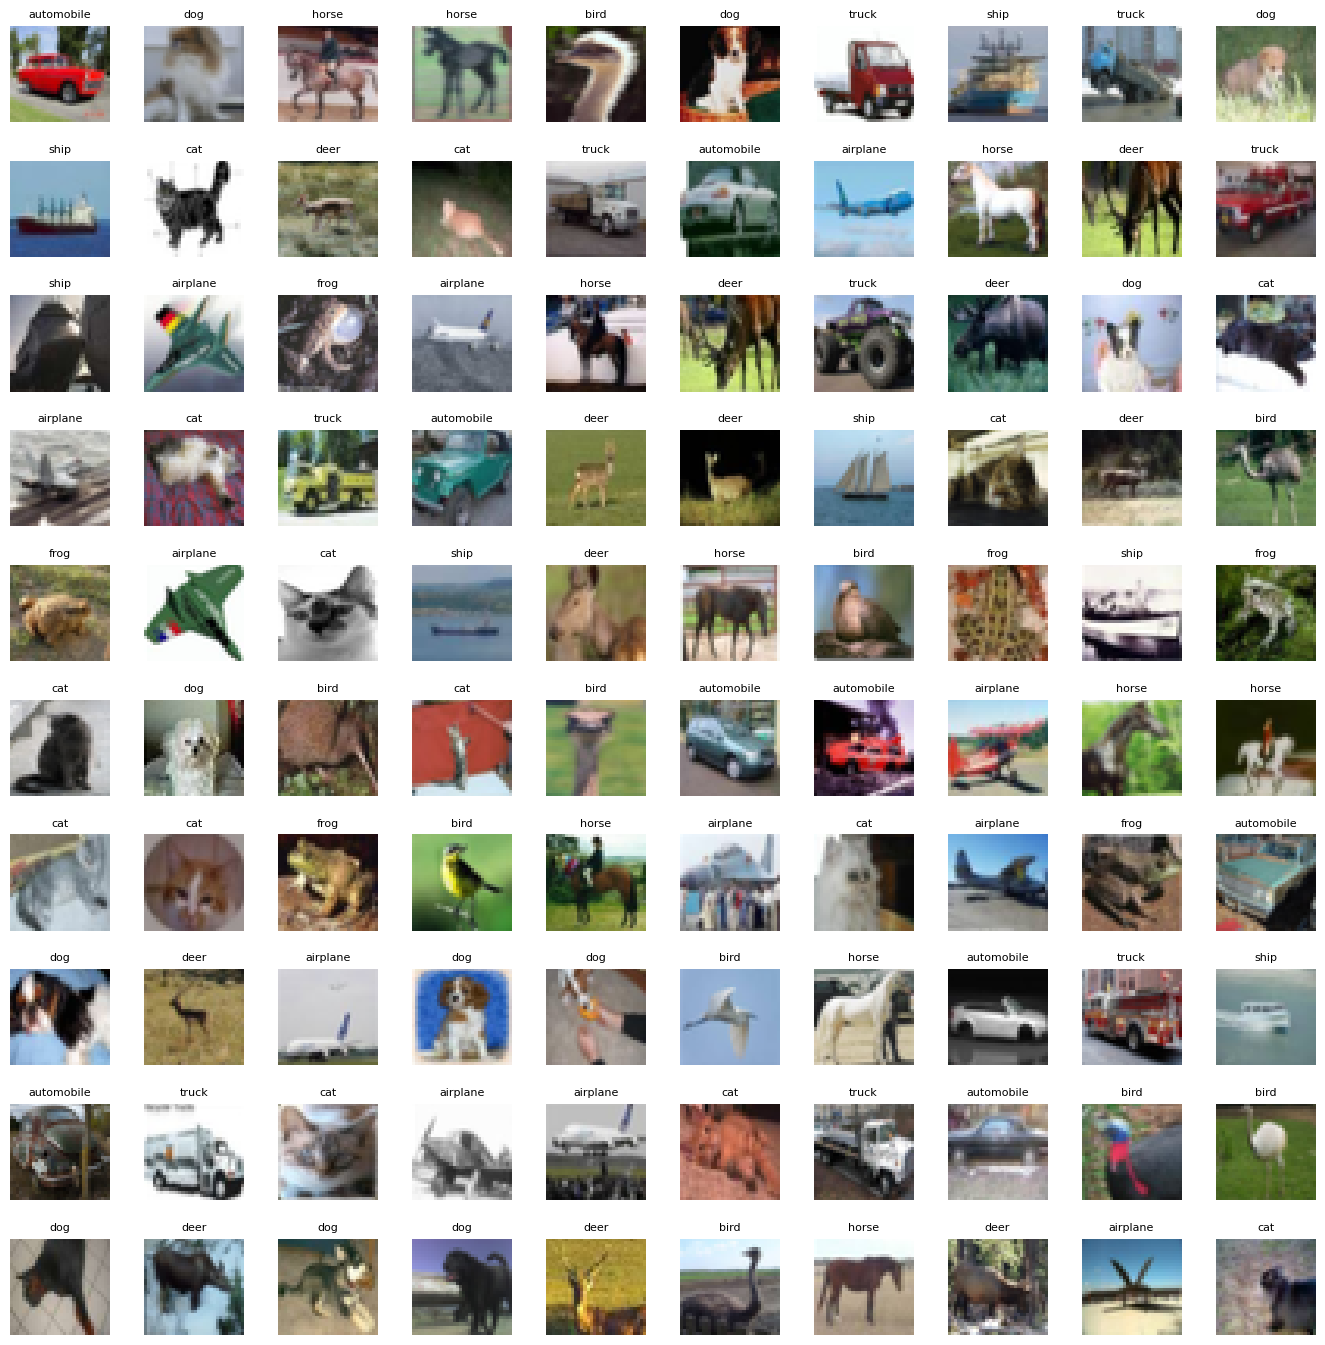

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)


Text(0.5, 1.0, 'Class distribution in training set')

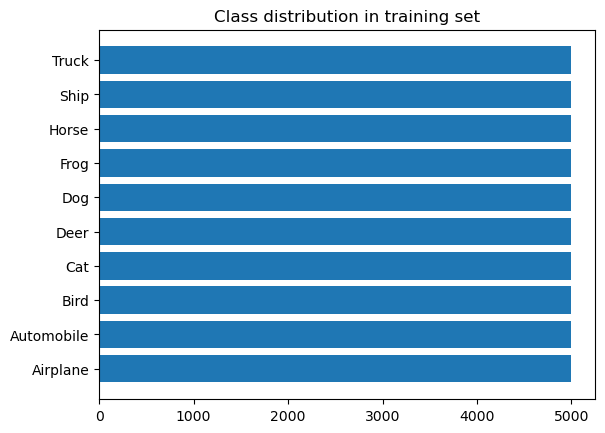

In [4]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

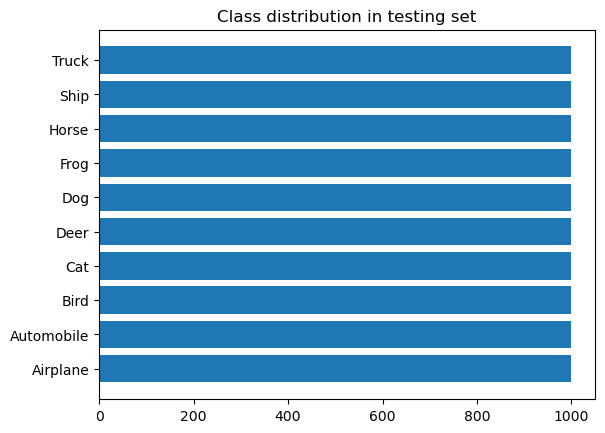

In [5]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

In [6]:
# Scale the data
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transform target variable into one-hotencoding
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [7]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model = Sequential()

# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [11]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50


1562/1562 [==============================] - 350s 219ms/step - loss: 1.6169 - accuracy: 0.4171 - precision: 0.6252 - recall: 0.2052 - val_loss: 1.4861 - val_accuracy: 0.4889 - val_precision: 0.6071 - val_recall: 0.3693
Epoch 2/50
1562/1562 [==============================] - 254s 163ms/step - loss: 1.2150 - accuracy: 0.5714 - precision: 0.7351 - recall: 0.4081 - val_loss: 0.9855 - val_accuracy: 0.6622 - val_precision: 0.7661 - val_recall: 0.5649
Epoch 3/50
1562/1562 [==============================] - 272s 174ms/step - loss: 1.0336 - accuracy: 0.6420 - precision: 0.7783 - recall: 0.5109 - val_loss: 0.9269 - val_accuracy: 0.6813 - val_precision: 0.7756 - val_recall: 0.5847
Epoch 4/50
1562/1562 [==============================] - 271s 173ms/step - loss: 0.9370 - accuracy: 0.6827 - precision: 0.7958 - recall: 0.5674 - val_loss: 0.9602 - val_accuracy: 0.6708 - val_precision: 0.7797 - val_recall: 0.5770
Epoch 5/50
1562/1562 [==============================] - 381s 244ms/step - loss

1562/1562 [==============================] - 279s 179ms/step - loss: 0.4173 - accuracy: 0.8603 - precision: 0.9000 - recall: 0.8236 - val_loss: 0.4833 - val_accuracy: 0.8470 - val_precision: 0.8808 - val_recall: 0.8166
Epoch 35/50
1562/1562 [==============================] - 277s 177ms/step - loss: 0.4054 - accuracy: 0.8624 - precision: 0.9000 - recall: 0.8277 - val_loss: 0.4224 - val_accuracy: 0.8639 - val_precision: 0.8917 - val_recall: 0.8440
Epoch 36/50
1562/1562 [==============================] - 279s 179ms/step - loss: 0.4054 - accuracy: 0.8608 - precision: 0.8996 - recall: 0.8263 - val_loss: 0.4110 - val_accuracy: 0.8658 - val_precision: 0.8962 - val_recall: 0.8413
Epoch 37/50
1562/1562 [==============================] - 261s 167ms/step - loss: 0.3996 - accuracy: 0.8628 - precision: 0.9009 - recall: 0.8280 - val_loss: 0.3895 - val_accuracy: 0.8681 - val_precision: 0.8980 - val_recall: 0.8478
Epoch 38/50
1562/1562 [==============================] - 469s 300ms/step - loss: 0.3951 

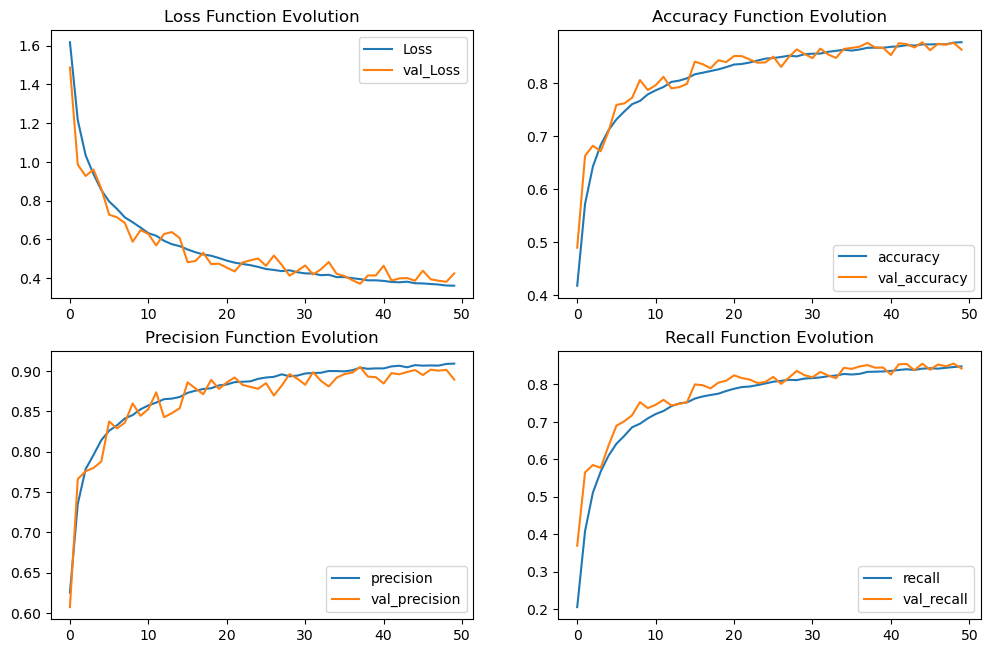

In [12]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 [==============================] - 25s 81ms/step - loss: 0.4246 - accuracy: 0.8625 - precision: 0.8893 - recall: 0.8423
Test Accuracy : 86.25%
313/313 [==============================] - 27s 85ms/step


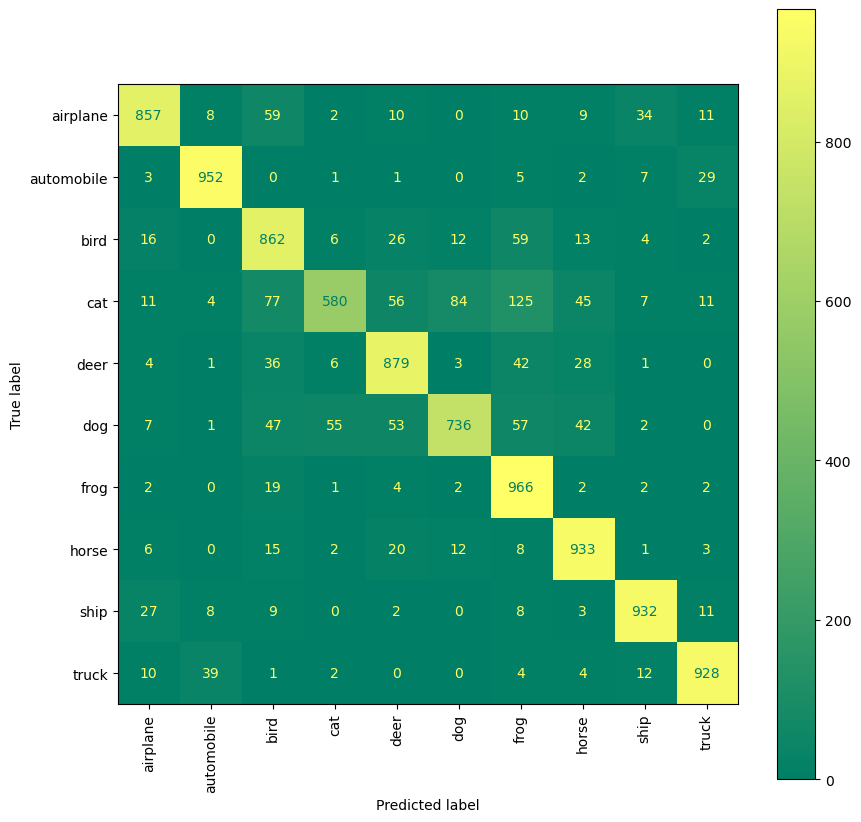

In [13]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1000
           1       0.94      0.95      0.95      1000
           2       0.77      0.86      0.81      1000
           3       0.89      0.58      0.70      1000
           4       0.84      0.88      0.86      1000
           5       0.87      0.74      0.80      1000
           6       0.75      0.97      0.85      1000
           7       0.86      0.93      0.90      1000
           8       0.93      0.93      0.93      1000
           9       0.93      0.93      0.93      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



 Image 100 is [4]
1/1 [==============================] - 0s 73ms/step
The model predict that image 100 is 4


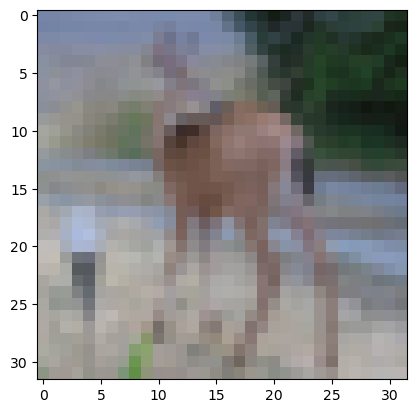

In [15]:
my_image = X_test[100]
plt.imshow(my_image)

# that's a Deer
print(f" Image 100 is {y_test[100]}")

# correctly predicted as a Deer
pred_100 = np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))
print(f"The model predict that image 100 is {pred_100}")

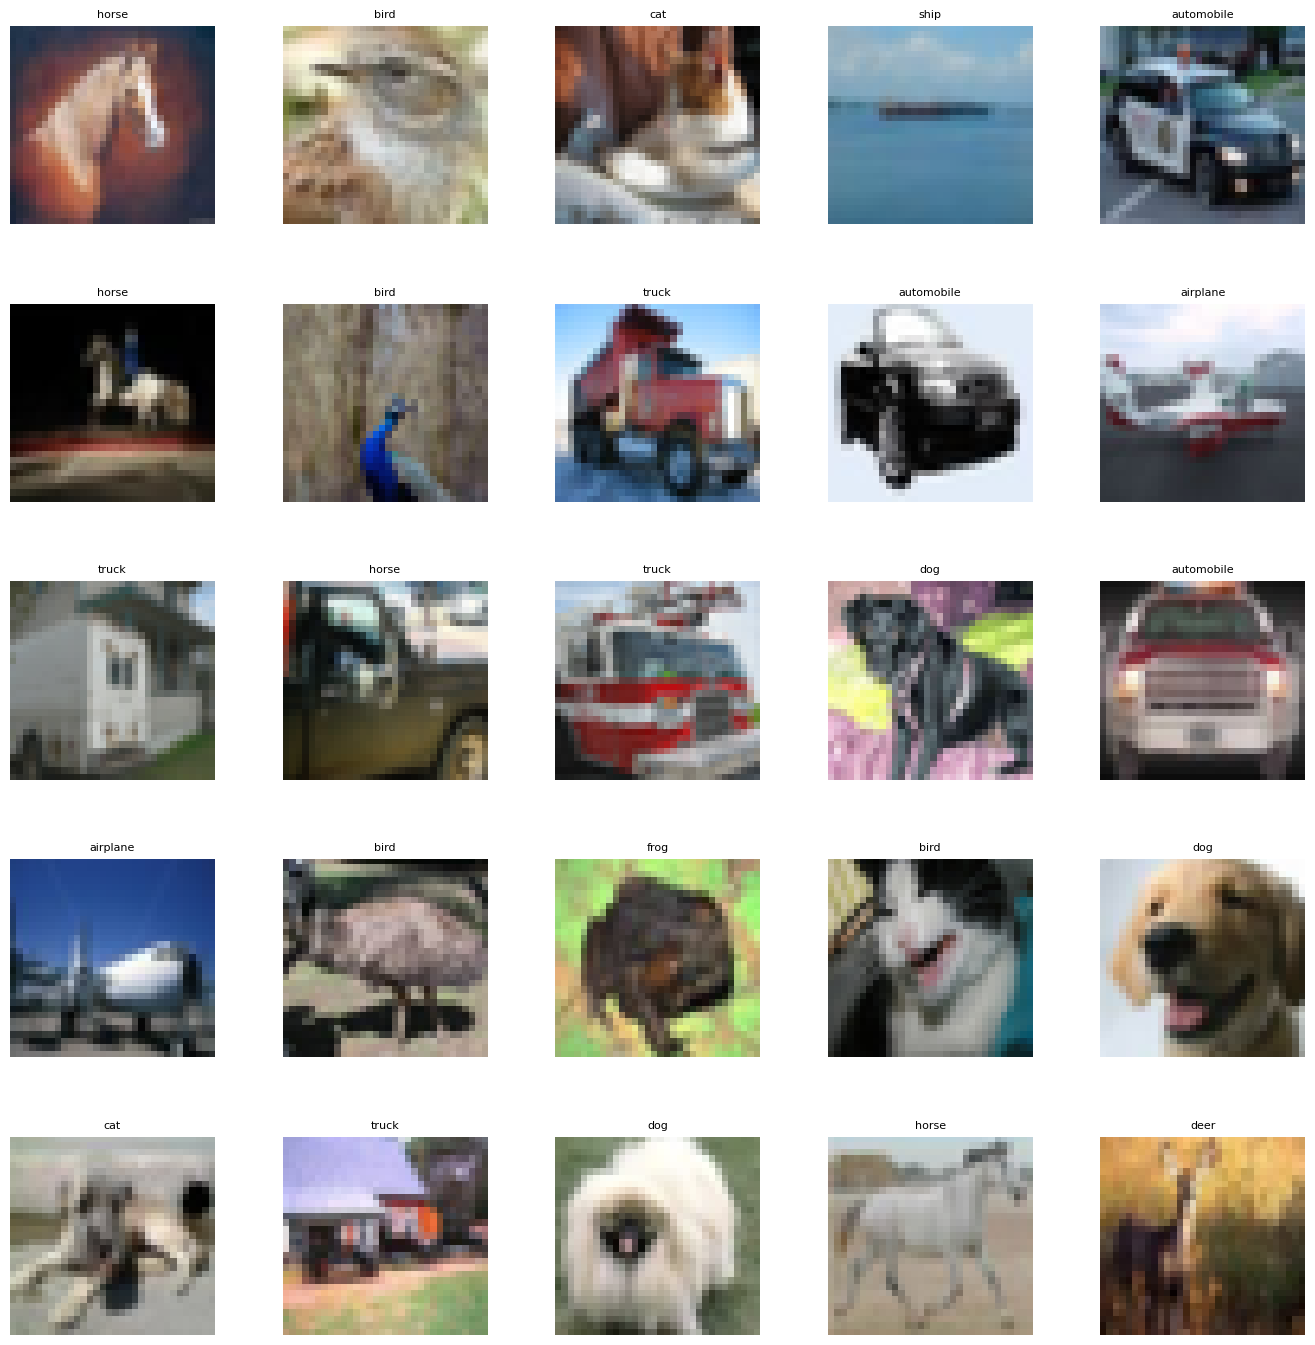

In [16]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [17]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

313/313 [==============================] - 27s 86ms/step


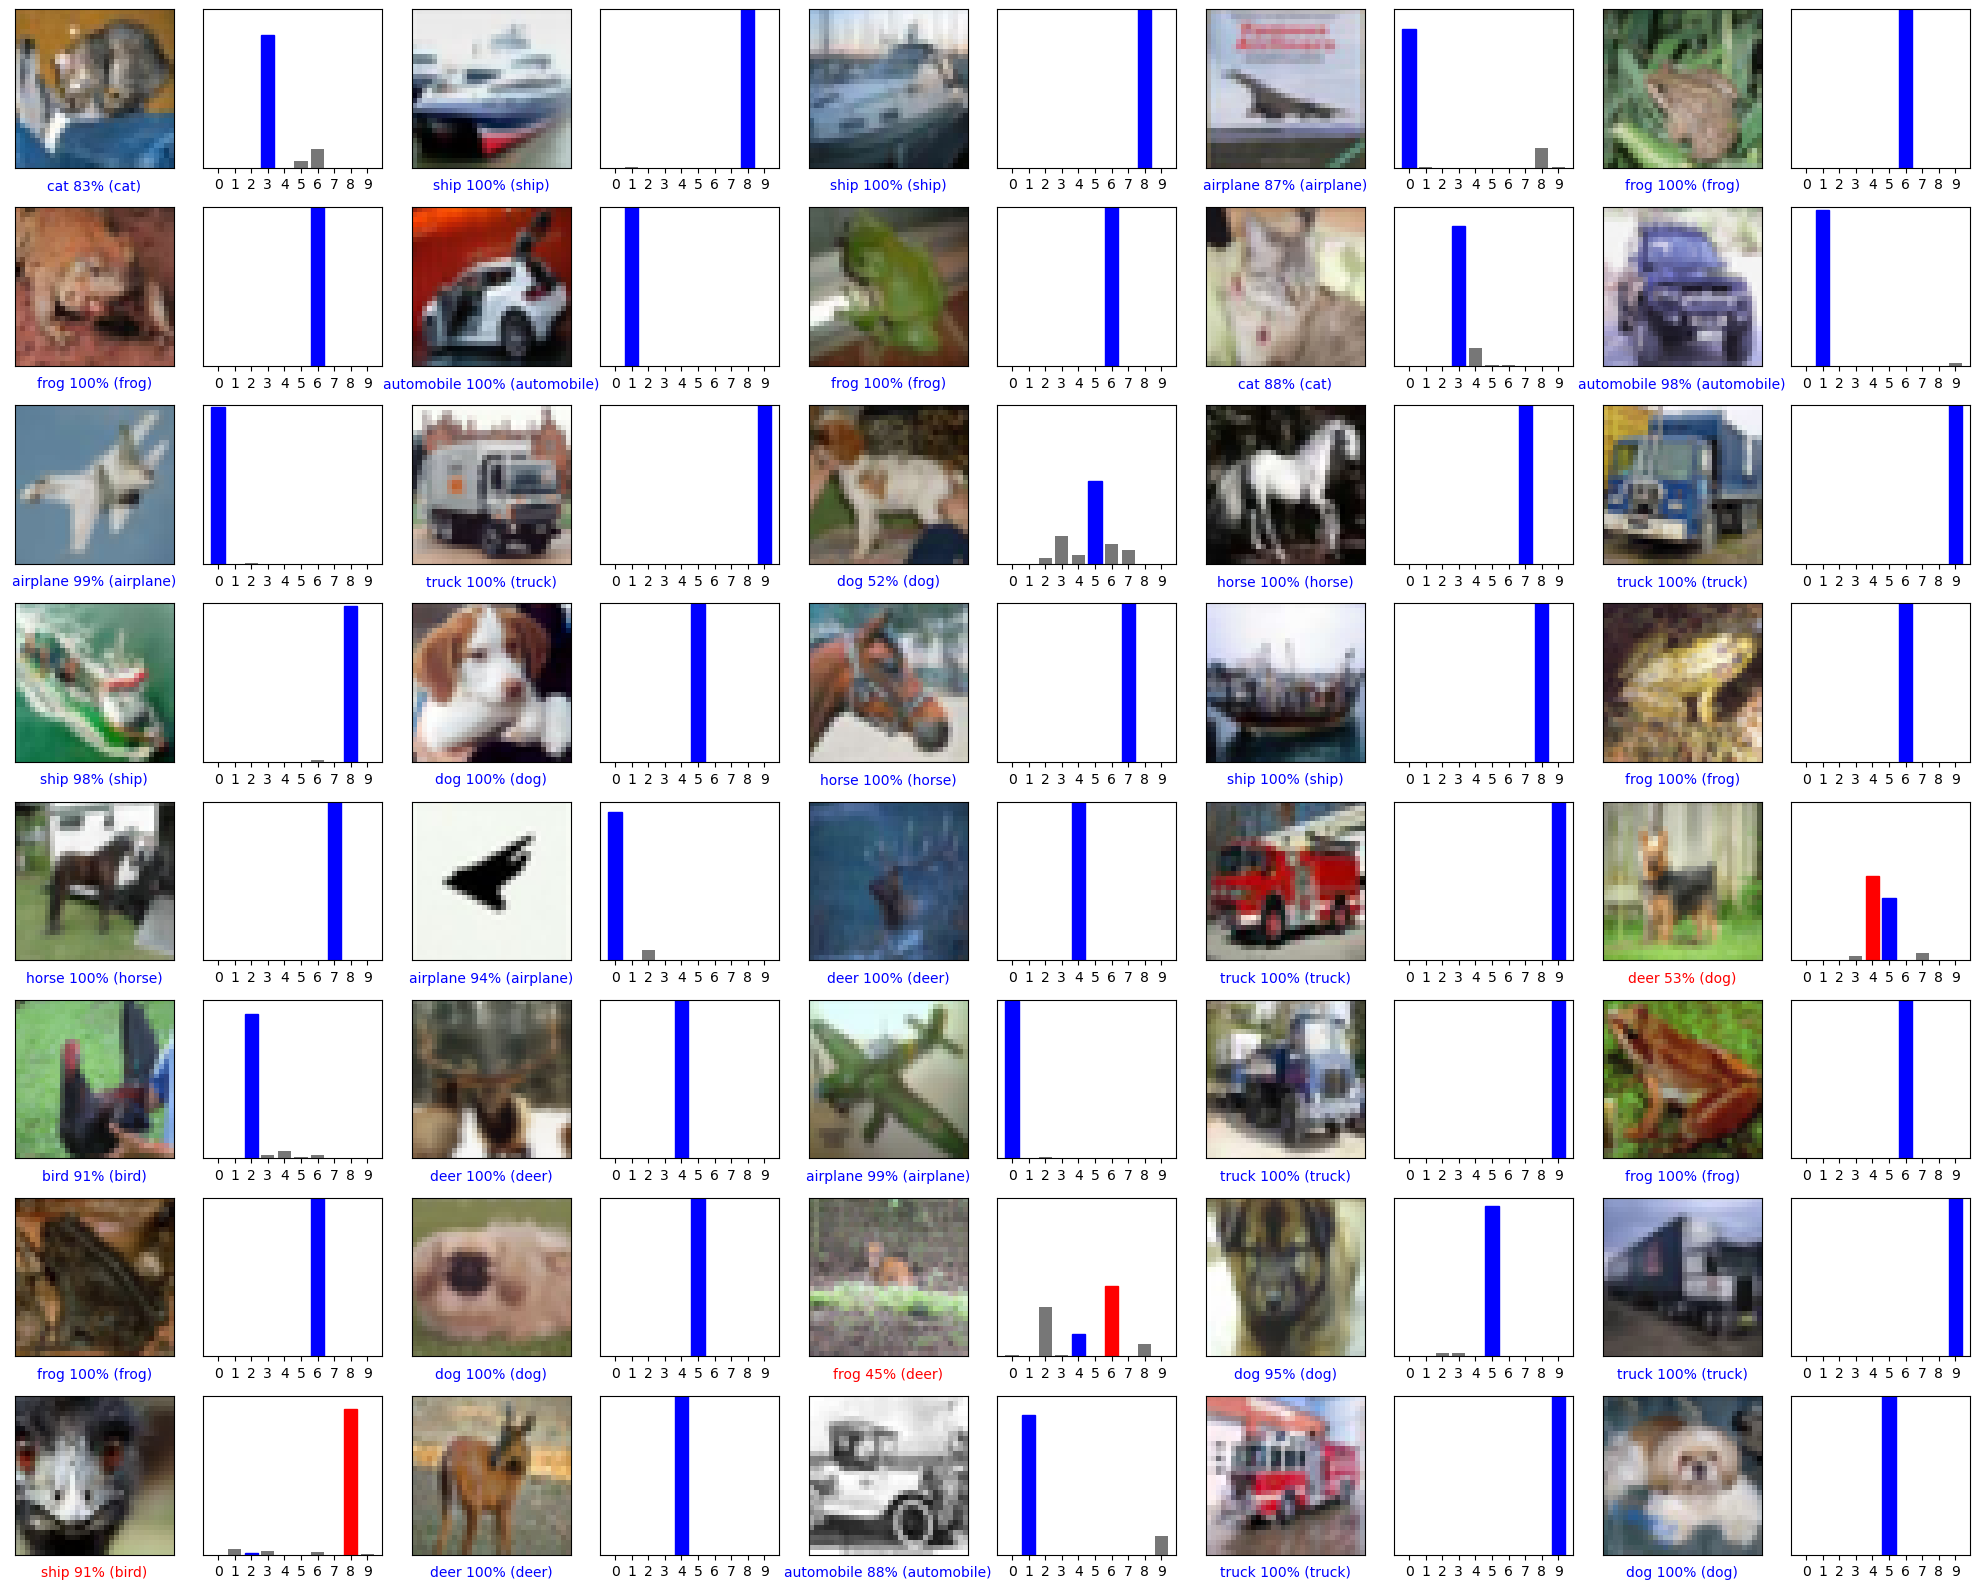

In [18]:
predictions = model.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()


In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
base_model = DenseNet121(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
model.add(base_model)
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

r = model.fit(train_generator, 
              epochs=100,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
             )

Epoch 1/100
1562/1562 [==============================] - 1448s 889ms/step - loss: 1.2527 - accuracy: 0.5802 - val_loss: 1.1842 - val_accuracy: 0.6012
Epoch 2/100
 575/1562 [==========>...................] - ETA: 13:06 - loss: 1.0538 - accuracy: 0.6476

In [ ]:
from tensorflow.keras.models import load_model

model.save('cnn_20_epochs.h5')